In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,label_binarize
from keras.layers import concatenate,Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate,Dropout,Softmax,BatchNormalization,Activation,DepthwiseConv2D ,ReLU,Add,GlobalAveragePooling2D,Multiply,Average
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import load_img,img_to_array,array_to_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import cv2
import seaborn as sns
import keras
import matplotlib.cm as cm
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler

2023-12-14 12:19:26.262094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 12:19:26.312329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 12:19:27.006397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set the path to the dataset
dataset_path = '/home/featurize/data/Rice_Dataset/Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):

    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        # Store the label for the image in the labels list
        labels.append(subfolder)

 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [3]:
X_train, X_remaining, Y_train, Y_remaining = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42)

test_ratio = 0.5
X_val, X_test, Y_val, Y_test = train_test_split(X_remaining, Y_remaining, test_size=test_ratio, random_state=42)

df_train = pd.DataFrame({'image': X_train, 'label': Y_train})
df_val = pd.DataFrame({'image': X_val, 'label': Y_val})
df_test = pd.DataFrame({'image': X_test, 'label': Y_test})

encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

In [4]:
input_shape=(50, 50, 3)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [5]:
def custom_accuracy(y_true, y_pred):
    y_true_argmax = tf.argmax(y_true, axis=1)
    y_pred_argmax = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_true_argmax, y_pred_argmax)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy
def custom_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load each model with pretrained weights and customize the top layer
def load_model(model_base, input_shape, num_classes):
    base_model = model_base(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile and train each model, and return the history
def train_model(model, train_data, val_data, epochs):
    model.compile(loss=custom_loss, optimizer="Adam", metrics=[custom_accuracy])
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history


# Load models
input_shape = (50, 50, 3)  # Example input shape
num_classes = 5  # Example number of classes
epochs = 10  # Example number of epochs
resnet_model = load_model(ResNet50, input_shape, num_classes)
vgg_model = load_model(VGG16, input_shape, num_classes)
EfficientNetB0_model = load_model(EfficientNetB0, input_shape, num_classes)
mobilenet_model = load_model(MobileNet, input_shape, num_classes)

# Train models and collect histories
histories = {}

2023-12-14 12:19:42.991336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 12:19:43.003989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 12:19:43.004303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
histories['ResNet'] = train_model(resnet_model, train_generator, val_generator, 10)
y_pred= resnet_model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_classes,target_names = rice_names))
cm = confusion_matrix(y_true, y_pred_classes)
overall_accuracy = np.trace(cm) / np.sum(cm)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))
print("Confusion Matrix")
print(cm)
print(f"Overall accuracy: {overall_accuracy:.4f}")
print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)

Epoch 1/10


2023-12-14 11:46:50.797552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-14 11:46:52.503356: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e3ad5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 11:46:52.503473: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-12-14 11:46:52.547437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 11:46:52.842718: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1641/1641 [==============================] - 146s 70ms/step - loss: 0.1110 - custom_accuracy: 0.6831 - val_loss: 0.2847 - val_custom_accuracy: 0.2778
Epoch 2/10
1641/1641 [==============================] - 105s 64ms/step - loss: 0.0227 - custom_accuracy: 0.9250 - val_loss: 0.1469 - val_custom_accuracy: 0.5351
Epoch 3/10
1641/1641 [==============================] - 104s 64ms/step - loss: 0.0165 - custom_accuracy: 0.9460 - val_loss: 0.1192 - val_custom_accuracy: 0.6484
Epoch 4/10
1641/1641 [==============================] - 110s 67ms/step - loss: 0.0145 - custom_accuracy: 0.9536 - val_loss: 0.1155 - val_custom_accuracy: 0.6762
Epoch 5/10
1641/1641 [==============================] - 126s 77ms/step - loss: 0.0131 - custom_accuracy: 0.9577 - val_loss: 0.0520 - val_custom_accuracy: 0.8331
Epoch 6/10
1641/1641 [==============================] - 106s 65ms/step - loss: 0.0121 - custom_accuracy: 0.9614 - val_loss: 0.1420 - val_custom_accuracy: 0.5835
Epoch 7/10
1641/1641 [=======================

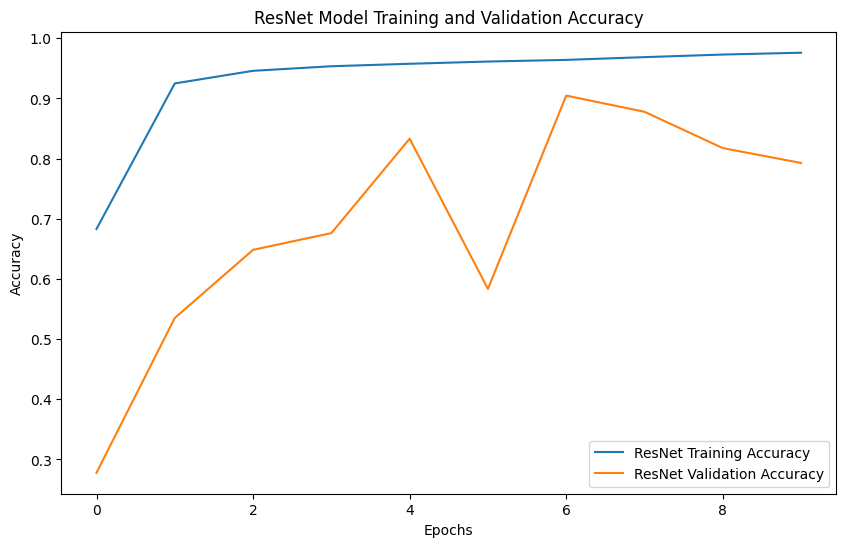

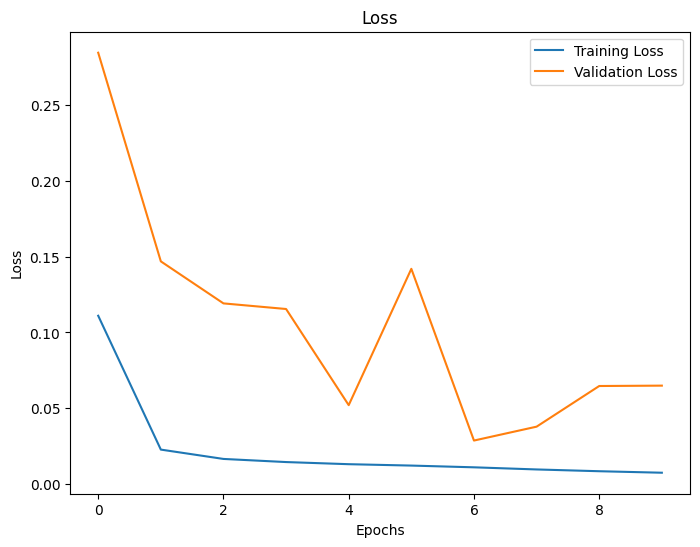

In [11]:
def plot_resnet_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['custom_accuracy'], label='ResNet Training Accuracy')
    plt.plot(history.history['val_custom_accuracy'], label='ResNet Validation Accuracy')
    plt.title('ResNet Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ResNet Model Training and Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_resnet_history(histories['ResNet'])

In [7]:
import keras.backend as K
import gc
K.clear_session()
gc.collect()
histories['VGG'] = train_model(vgg_model, train_generator, val_generator, 10)
y_pred= vgg_model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_classes,target_names = rice_names))
cm = confusion_matrix(y_true, y_pred_classes)
overall_accuracy = np.trace(cm) / np.sum(cm)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))
print("Confusion Matrix")
print(cm)
print(f"Overall accuracy: {overall_accuracy:.4f}")
print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)
def plot_vgg_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['custom_accuracy'], label='VGG Training Accuracy')
    plt.plot(history.history['val_custom_accuracy'], label='VGG Validation Accuracy')
    plt.title('VGG16 Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('VGG16 Model Training and Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10


2023-12-14 12:19:51.659107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-14 12:19:52.543483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f51032424c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 12:19:52.543523: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-12-14 12:19:52.548450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 12:19:52.693377: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1641/1641 [==============================] - 97s 56ms/step - loss: 0.1600 - custom_accuracy: 0.1978 - val_loss: 0.1600 - val_custom_accuracy: 0.1995
Epoch 2/10
1641/1641 [==============================] - 94s 57ms/step - loss: 0.1600 - custom_accuracy: 0.1987 - val_loss: 0.1600 - val_custom_accuracy: 0.1999
Epoch 3/10
1641/1641 [==============================] - 100s 61ms/step - loss: 0.1600 - custom_accuracy: 0.1972 - val_loss: 0.1600 - val_custom_accuracy: 0.2008
Epoch 4/10
1641/1641 [==============================] - 94s 57ms/step - loss: 0.1600 - custom_accuracy: 0.1998 - val_loss: 0.1600 - val_custom_accuracy: 0.2008
Epoch 5/10
1641/1641 [==============================] - 95s 58ms/step - loss: 0.1600 - custom_accuracy: 0.1999 - val_loss: 0.1600 - val_custom_accuracy: 0.1969
Epoch 6/10
1641/1641 [==============================] - 98s 60ms/step - loss: 0.1600 - custom_accuracy: 0.1979 - val_loss: 0.1600 - val_custom_accuracy: 0.2008
Epoch 7/10
1641/1641 [============================

/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


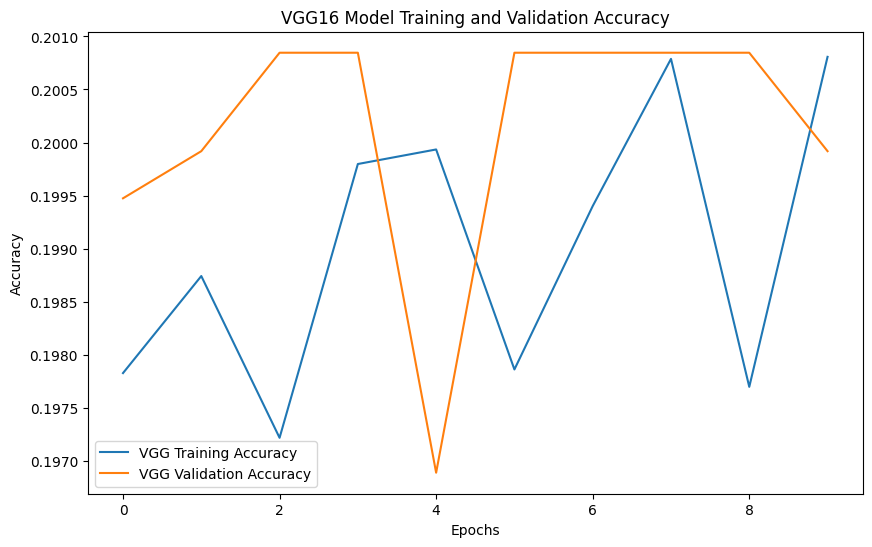

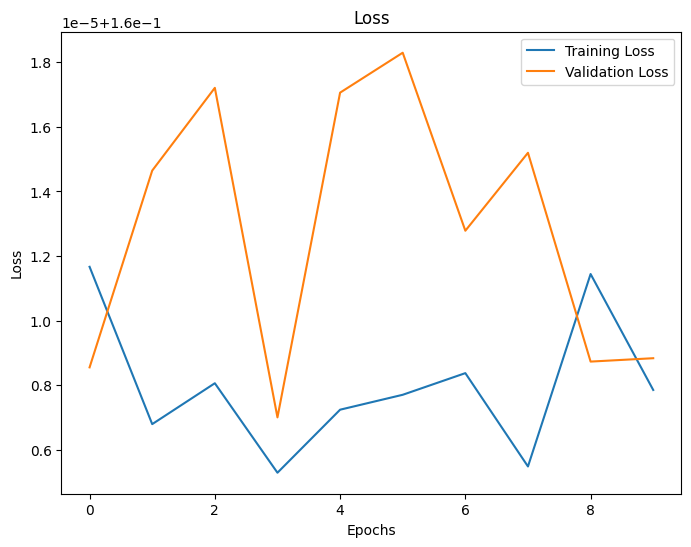

In [8]:
plot_vgg_history(histories['VGG'])

In [9]:
histories['EfficientNetB0'] = train_model(EfficientNetB0_model, train_generator, val_generator, 10)

Epoch 1/10


2023-12-14 12:39:33.008440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1641/1641 [==============================] - 170s 84ms/step - loss: 0.0491 - custom_accuracy: 0.8232 - val_loss: 0.3175 - val_custom_accuracy: 0.2034
Epoch 2/10
1641/1641 [==============================] - 130s 79ms/step - loss: 0.0167 - custom_accuracy: 0.9472 - val_loss: 0.0916 - val_custom_accuracy: 0.6979
Epoch 3/10
1641/1641 [==============================] - 116s 71ms/step - loss: 0.0126 - custom_accuracy: 0.9609 - val_loss: 0.2480 - val_custom_accuracy: 0.3335
Epoch 4/10
1641/1641 [==============================] - 125s 76ms/step - loss: 0.0098 - custom_accuracy: 0.9695 - val_loss: 0.0781 - val_custom_accuracy: 0.7501
Epoch 5/10
1641/1641 [==============================] - 123s 75ms/step - loss: 0.0085 - custom_accuracy: 0.9741 - val_loss: 0.1647 - val_custom_accuracy: 0.5482
Epoch 6/10
1641/1641 [==============================] - 115s 70ms/step - loss: 0.0069 - custom_accuracy: 0.9784 - val_loss: 0.0075 - val_custom_accuracy: 0.9775
Epoch 7/10
1641/1641 [=======================

NameError: name 'densenet_model' is not defined

352/352 [==============================] - 15s 42ms/step
              precision    recall  f1-score   support

   Karacadag       0.99      0.75      0.86      2227
     Arborio       0.66      1.00      0.79      2229
      Ipsala       0.83      1.00      0.90      2368
     Basmati       0.97      0.45      0.62      2261
     Jasmine       0.94      0.98      0.96      2165

    accuracy                           0.84     11250
   macro avg       0.88      0.84      0.83     11250
weighted avg       0.88      0.84      0.83     11250

Confusion Matrix
[[1679    4  391   27  126]
 [   0 2226    3    0    0]
 [   0    0 2368    0    0]
 [  16 1129   86 1022    8]
 [   3   17   18    0 2127]]
Overall accuracy: 0.8375
Sensitivity for each class: [0.75392905 0.9986541  1.         0.45201238 0.98244804]
Specificity for each class: [0.997894270198382, 0.8725196763108303, 0.9439315469488854, 0.9969963288463678, 0.9852504127682994]


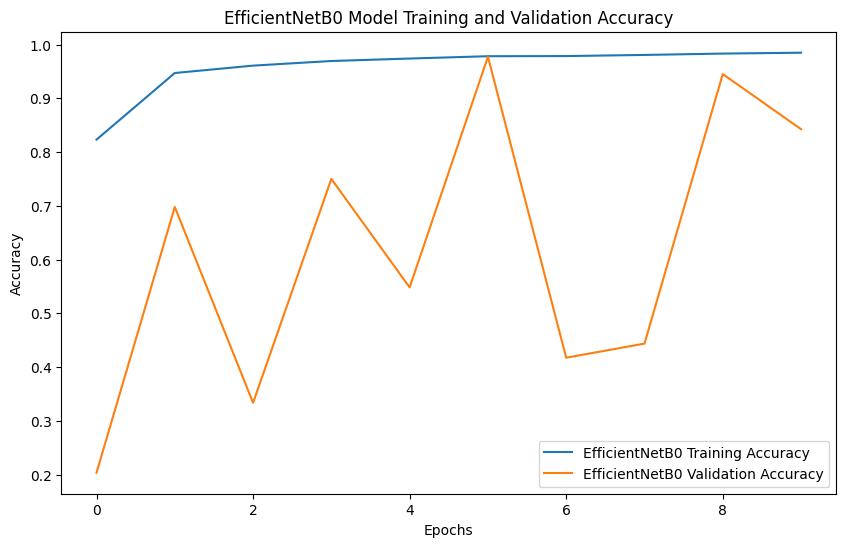

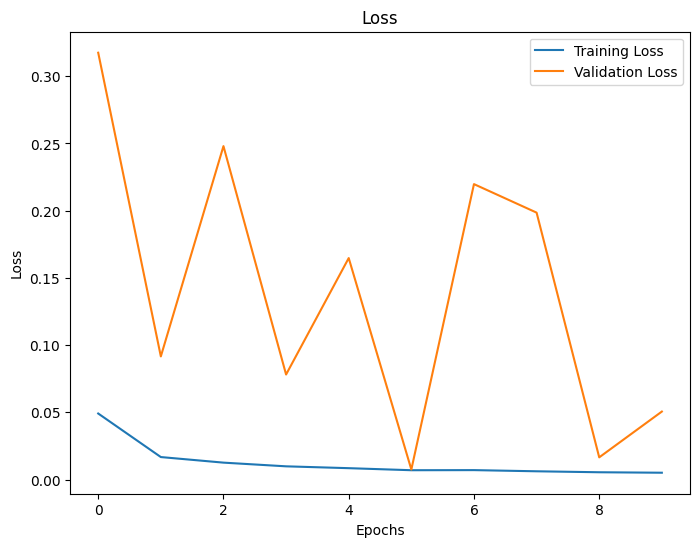

In [12]:
y_pred= EfficientNetB0_model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_classes,target_names = rice_names))
cm = confusion_matrix(y_true, y_pred_classes)
overall_accuracy = np.trace(cm) / np.sum(cm)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))
print("Confusion Matrix")
print(cm)
print(f"Overall accuracy: {overall_accuracy:.4f}")
print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)
def plot_EfficientNetB0_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['custom_accuracy'], label='EfficientNetB0 Training Accuracy')
    plt.plot(history.history['val_custom_accuracy'], label='EfficientNetB0 Validation Accuracy')
    plt.title('EfficientNetB0 Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB0 Model Training and Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_EfficientNetB0_history(histories['EfficientNetB0'])

Epoch 1/10
1641/1641 [==============================] - 98s 53ms/step - loss: 0.0457 - custom_accuracy: 0.8402 - val_loss: 0.1053 - val_custom_accuracy: 0.7070
Epoch 2/10
1641/1641 [==============================] - 80s 49ms/step - loss: 0.0233 - custom_accuracy: 0.9255 - val_loss: 0.2986 - val_custom_accuracy: 0.2376
Epoch 3/10
1641/1641 [==============================] - 94s 57ms/step - loss: 0.0150 - custom_accuracy: 0.9536 - val_loss: 0.2528 - val_custom_accuracy: 0.3375
Epoch 4/10
1641/1641 [==============================] - 93s 56ms/step - loss: 0.0120 - custom_accuracy: 0.9627 - val_loss: 0.0082 - val_custom_accuracy: 0.9763
Epoch 5/10
1641/1641 [==============================] - 106s 65ms/step - loss: 0.0105 - custom_accuracy: 0.9681 - val_loss: 0.0204 - val_custom_accuracy: 0.9422
Epoch 6/10
1641/1641 [==============================] - 98s 59ms/step - loss: 0.0086 - custom_accuracy: 0.9738 - val_loss: 0.0922 - val_custom_accuracy: 0.7211
Epoch 7/10
1641/1641 [=================

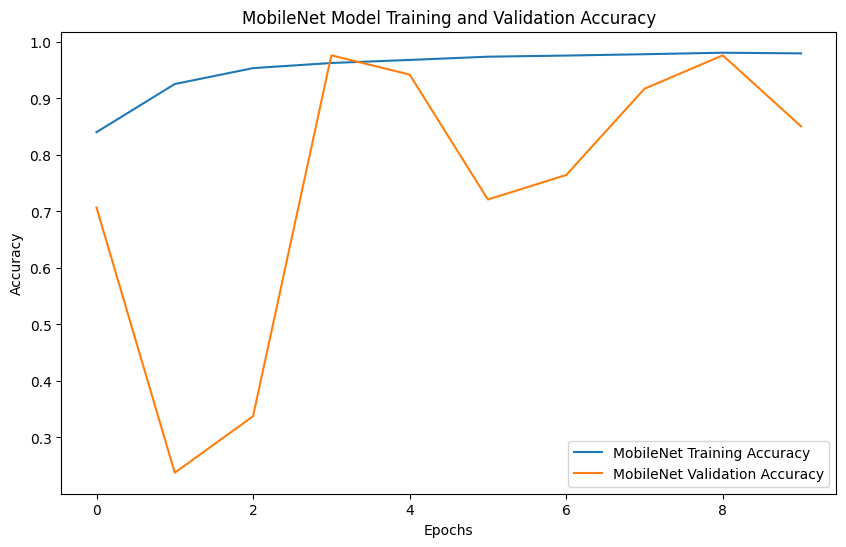

In [13]:
import keras.backend as K
import gc
K.clear_session()
gc.collect()
histories['MobileNet'] = train_model(mobilenet_model,  train_generator, val_generator, 10)
y_pred= mobilenet_model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_classes,target_names = rice_names))
cm = confusion_matrix(y_true, y_pred_classes)
overall_accuracy = np.trace(cm) / np.sum(cm)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))
print("Confusion Matrix")
print(cm)
print(f"Overall accuracy: {overall_accuracy:.4f}")
print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)
def plot_mobile_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['custom_accuracy'], label='MobileNet Training Accuracy')
    plt.plot(history.history['val_custom_accuracy'], label='MobileNet Validation Accuracy')
    plt.title('MobileNet Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MobileNet Model Training and Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_mobile_history(histories['MobileNet'])

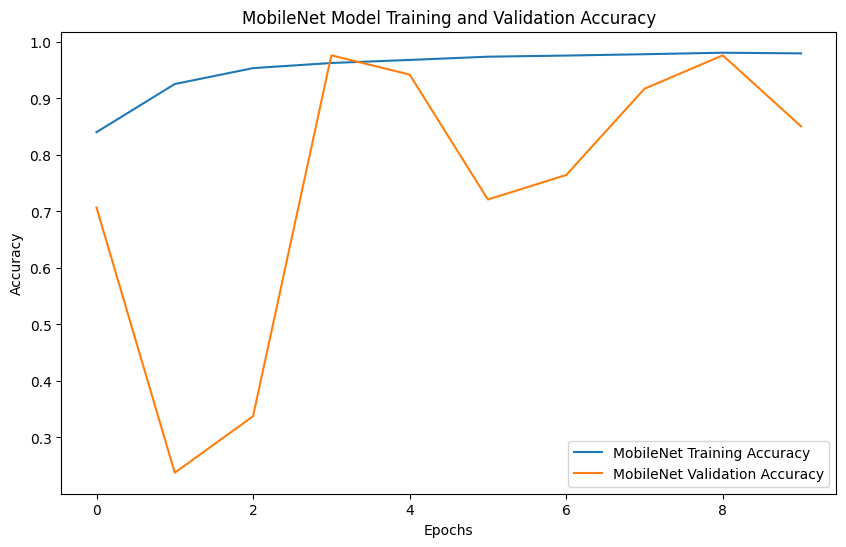

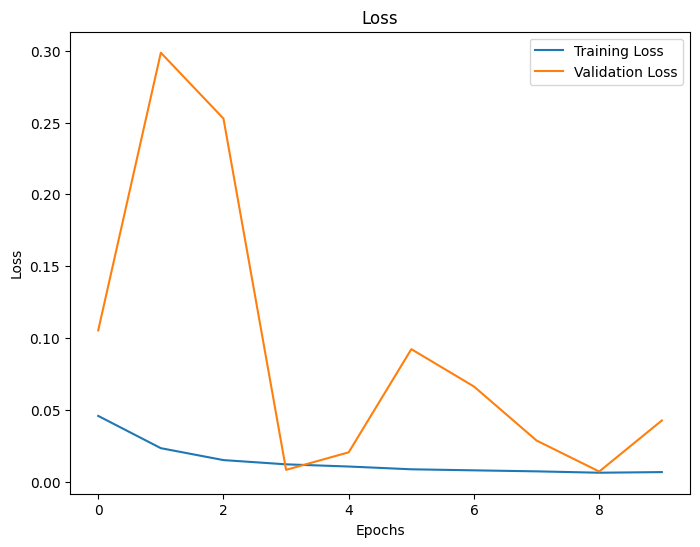

In [15]:
def plot_mobile_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['custom_accuracy'], label='MobileNet Training Accuracy')
    plt.plot(history.history['val_custom_accuracy'], label='MobileNet Validation Accuracy')
    plt.title('MobileNet Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MobileNet Model Training and Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_mobile_history(histories['MobileNet'])

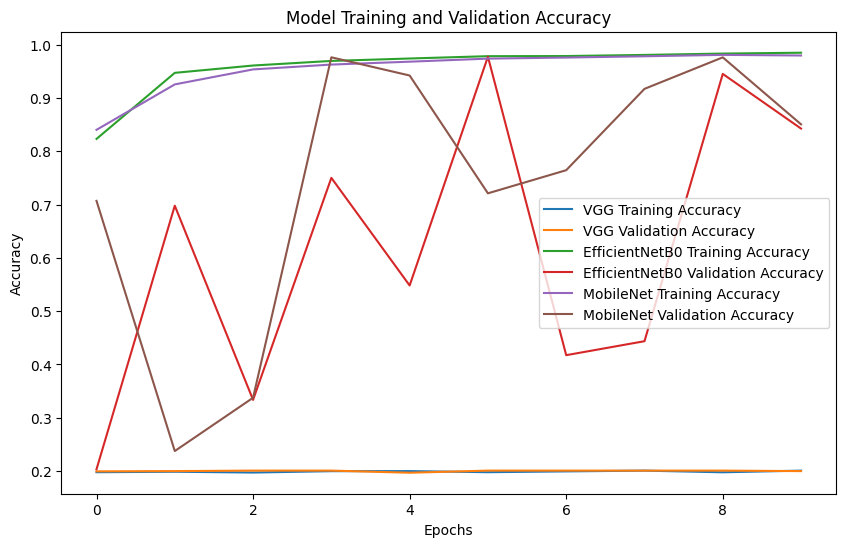

In [14]:
def plot_histories(histories):
    plt.figure(figsize=(10, 6))
    models = ['ResNet', 'VGG', 'DenseNet121', 'MobileNet']
    for name, history in histories.items():
        plt.plot(history.history['custom_accuracy'], label=f'{name} Training Accuracy')
        plt.plot(history.history['val_custom_accuracy'], label=f'{name} Validation Accuracy')
    plt.title('Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_histories(histories)